clasess 16
num clasees 16


/Users/simranbirkaur/Python_Miniconda/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.0977 - loss: 2.7615 - val_accuracy: 0.2031 - val_loss: 2.7415
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0951 - loss: 2.7597 - val_accuracy: 0.2656 - val_loss: 2.7130
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1823 - loss: 2.7009 - val_accuracy: 0.3438 - val_loss: 2.6870
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1680 - loss: 2.6952 - val_accuracy: 0.5156 - val_loss: 2.6617
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2682 - loss: 2.6615 - val_accuracy: 0.6562 - val_loss: 2.6366
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3620 - loss: 2.6178 - val_accuracy: 0.7188 - val_loss: 2.6110
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3776 - loss: 2.6220 - val_accuracy: 0.8438 - val_loss: 2.5851
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3607 - loss: 2.5794 - val_accuracy: 0.9062 - val_loss

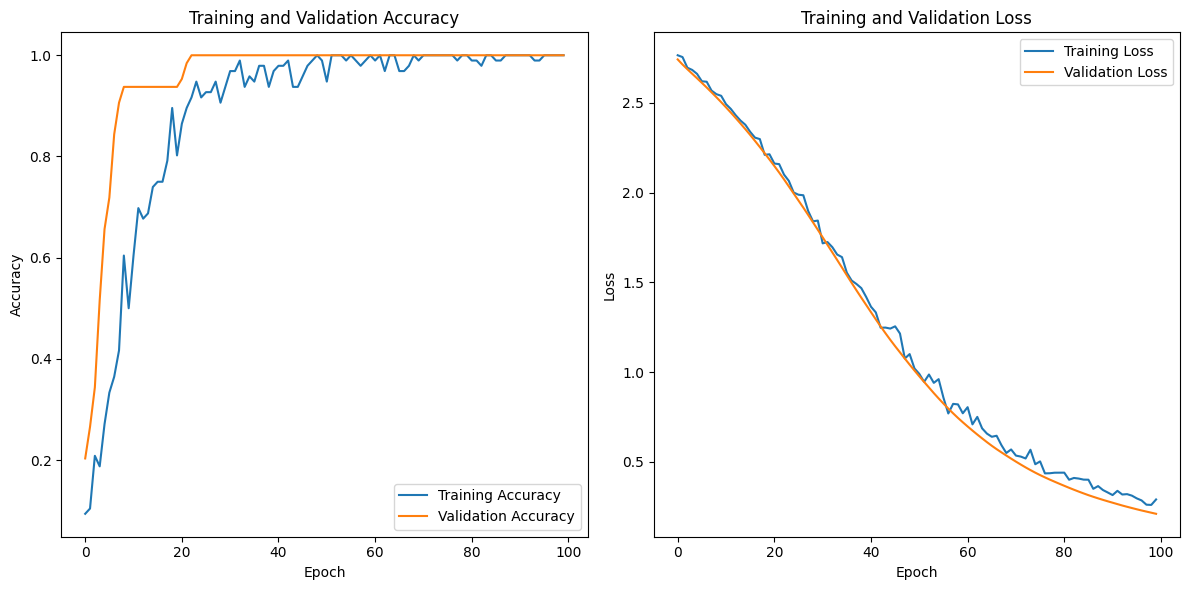

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO:root:Confidence Scores: [0.7830243  0.87382346 0.78915375 0.868768   0.91663414 0.86195
 0.7140798  0.77293575 0.8020005  0.8006075  0.882891   0.7627943
 0.8920681  0.85928327 0.7188111  0.83299124 0.7534577  0.8049269
 0.8079607  0.8987901  0.82176703 0.8970304  0.7843415  0.78831095
 0.79540336 0.6867251  0.7742076  0.8928238  0.820414   0.78585494
 0.7754582  0.90729815 0.8828415  0.6496859  0.73602355 0.896693
 0.7881319  0.8552399  0.6935512  0.9034606  0.7113342  0.799233
 0.8451802  0.8693925  0.8886539  0.8022064  0.77625823 0.8432529
 0.84207934 0.8381977  0.8919084  0.9307493  0.7586883  0.7453773
 0.8072199  0.7670918  0.80315375 0.7437291  0.87045884 0.9133206
 0.7374421  0.7503799  0.6269342  0.90662134]
INFO:root:Test Accuracy: 1.0


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         4

    accuracy                           1.00        64
   

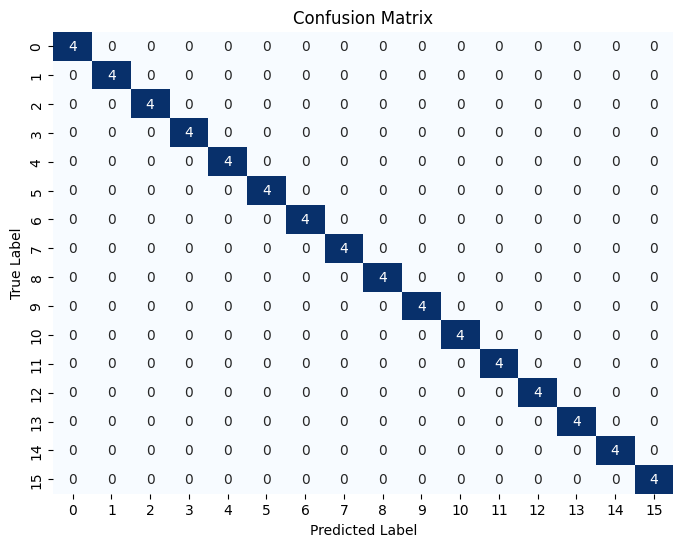

In [6]:
import numpy as np
import os
import cv2
import dlib
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Configure logging
logging.basicConfig(level=logging.INFO)

def load_face_recognition_models():
    """
    Load the face detection, landmark predictor, and face recognition models.
    """
    face_detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor("/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/Dlib_files/shape_predictor_68_face_landmarks.dat")
    face_encoder = dlib.face_recognition_model_v1("/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/Dlib_files/dlib_face_recognition_resnet_model_v1.dat")
    return face_detector, shape_predictor, face_encoder


def extract_face_encodings(image, face_detector, shape_predictor, face_encoder):
    """
    Extract facial encodings from an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = face_detector(gray, 1)
    encodings = [np.array(face_encoder.compute_face_descriptor(image, shape_predictor(gray, rect))) for rect in rects]
    return encodings


def preprocess_images_and_labels(images_folder, face_detector, shape_predictor, face_encoder):
    """
    Preprocess images and extract encodings and labels.
    """
    encodings = []
    labels = []
    for root, dirs, files in os.walk(images_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is None:
                    logging.error(f"Failed to load image: {image_path}")
                    continue
                face_encs = extract_face_encodings(image, face_detector, shape_predictor, face_encoder)
                encodings.extend(face_encs)
                #labels.extend([os.path.basename(root)])
                labels.extend([os.path.basename(root)] * len(face_encs))

                #Saving encosings in a pickle file
                #save_encodings(labels, face_encs )

    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    num_classes = len(le.classes_)
    print("clasess", num_classes)
    labels_encoded = to_categorical(labels_encoded, num_classes)  # Convert labels to one-hot encoding
    return np.array(encodings), np.array(labels_encoded), num_classes


def build_model(input_shape, num_classes):
    """
    Build the CNN model.
    """
    print("num clasees", num_classes)
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained CNN model.
    """
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    confidence_scores = np.max(y_pred_prob, axis=1)
    logging.info("Confidence Scores: %s", confidence_scores)
    accuracy = accuracy_score(y_true, y_pred)
    logging.info("Test Accuracy: %s", accuracy)
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred)


def loadModel():
    # Load face recognition models
    face_detector, shape_predictor, face_encoder = load_face_recognition_models()

    # Preprocess images and labels
    encodings, labels, num_classes = preprocess_images_and_labels('/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/dataset/images', face_detector, shape_predictor, face_encoder)

    # Preprocess data
    X_train, X_test, y_train, y_test = train_test_split(encodings, labels, test_size=0.4, random_state=42,
                                                        stratify=labels)

    # Build CNN model
    model = build_model(input_shape=X_train.shape[1:], num_classes=num_classes)

    # Train CNN model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

    # Plot Training History
    plot_training_history(history)
    
    # Evaluate CNN model
    evaluate_model(model, X_test, y_test)


def plot_training_history(history):
    """
    Plot training history (accuracy and loss).
    """
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix using seaborn.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


loadModel()
